In [2]:
pip install langchain_core langchain-openai langgraph python-dotenv

  Using cached msgpack-1.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.4 kB)
Using cached msgpack-1.1.0-cp313-cp313-macosx_11_0_arm64.whl (81 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


In [5]:
llm = ChatOpenAI(model="gpt-4o",api_key=OPENAI_API_KEY)

In [27]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query:str = Field(None,description="Query that is optimized the search query")
    justification:str = Field(None,justification= "Why the query is relavent to user's response")
structured_llm = llm.with_structured_output(SearchQuery)

output = structured_llm.invoke("How does Calcium CT score related to high cholestrol")
print(output.search_query)
print(output.justification)

Correlation between Calcium CT score and high cholesterol
Investigating how a high Calcium CT score, indicative of coronary artery calcification, is linked to cholesterol levels, typically LDL, can explain the relationship between cardiovascular disease risk and cholesterol management.


In [28]:
# Define a tool
def multiply(a:int,b:int) -> int:
    return a * b 

llm_with_tools = llm.bind_tools([multiply])
msg = llm_with_tools.invoke("What is 2 times 3 ?")
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_I0dhs4HDWwruylLUnmSBKDmQ',
  'type': 'tool_call'}]

In [29]:
from typing_extensions import TypedDict

# Creating a state with topic, joke , improve_joke , final_joke
class State(TypedDict): 
    topic:str
    joke:str
    improve_joke:str
    final_joke:str


In [39]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improve_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improve_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

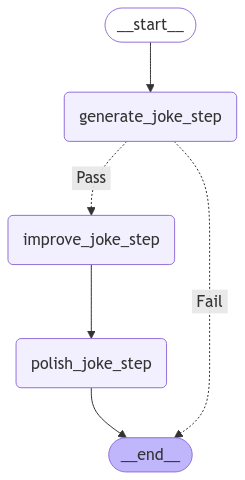

In [40]:

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke_step", generate_joke)
workflow.add_node("improve_joke_step", improve_joke)
workflow.add_node("polish_joke_step", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke_step")
workflow.add_conditional_edges(
    "generate_joke_step", check_punchline, {"Pass": "improve_joke_step", "Fail": END}
)
workflow.add_edge("improve_joke_step", "polish_joke_step")
workflow.add_edge("polish_joke_step", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [41]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke_step" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Joke failed quality gate - no punchline detected!


In [59]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [60]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


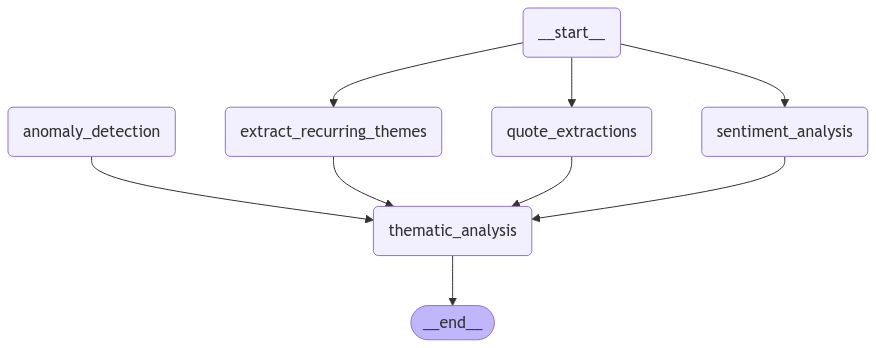

In [170]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("extract_recurring_themes", call_llm_1)
parallel_builder.add_node("sentiment_analysis", call_llm_2)
parallel_builder.add_node("quote_extractions", call_llm_3)
parallel_builder.add_node("anomaly_detection", call_llm_3)

parallel_builder.add_node("thematic_analysis", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "extract_recurring_themes")
parallel_builder.add_edge(START, "sentiment_analysis")
parallel_builder.add_edge(START, "quote_extractions")
parallel_builder.add_edge("extract_recurring_themes", "thematic_analysis")
parallel_builder.add_edge("sentiment_analysis", "thematic_analysis")
parallel_builder.add_edge("quote_extractions", "thematic_analysis")
parallel_builder.add_edge("anomaly_detection", "thematic_analysis")

parallel_builder.add_edge("thematic_analysis", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [65]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Title: The Enchanted Whiskers

In a quaint little village nestled between rolling hills and a shimmering silver stream, there existed a peculiar phenomenon that the townsfolk spoke of in hushed awe. It was the tale of Willowbrook's enigmatic feline society, known to only a few as the Enchanted Whiskers.

The cats of Willowbrook were no ordinary creatures. They were regal, appearing to glide rather than walk. Their coats shimmered in the sunlight, each hair twinkling like spun gold or moonlit silver. But it was their eyes—each a deep well of vibrant hues that seemed borrowed from the most exquisite of rainbows—that truly mesmerized those fortunate enough to catch a glimpse.

The story begins with Eliza, a young girl with a wild imagination and an insatiable curiosity about the world. Eliza had always felt a strong connection to animals, especially cats. Her own ginger tabby, Percy, was not just a pet but her closest companion in her adv

In [86]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [87]:
class State(TypedDict):
    input:str
    decision:str
    output:str

In [99]:
from langchain_core.messages import HumanMessage, SystemMessage

def llm_call_1(state:State):
    """Write a story"""
    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state:State):
    """Write a joke"""
    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state:State):
    """Write a peom"""
    print("Write a peom")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}
    
def route_decision(state:State):
    if state["decision"] == "story":
        return "llm_call_1_step"
    elif state["decision"] == "joke":
        return "llm_call_2_step"
    elif state["decision"] == "peom":
        return "llm_call_3_step"
    


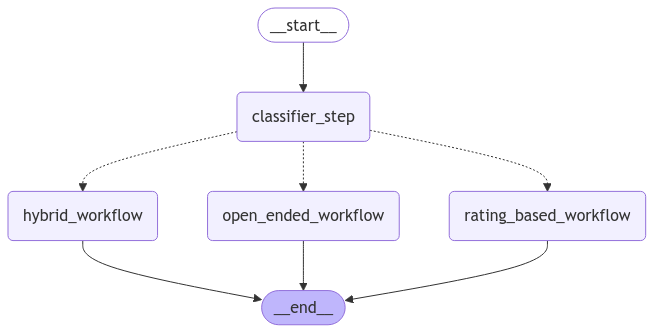

In [169]:
router_builder = StateGraph(State)

router_builder.add_node("open_ended_workflow",llm_call_1)
router_builder.add_node("rating_based_workflow", llm_call_2)
router_builder.add_node("hybrid_workflow", llm_call_3)
router_builder.add_node("classifier_step", llm_call_router)


router_builder.add_edge(START,"classifier_step")
router_builder.add_conditional_edges(
    "classifier_step",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "open_ended_workflow": "open_ended_workflow",
        "rating_based_workflow": "rating_based_workflow",
        "hybrid_workflow": "hybrid_workflow",
    })

router_builder.add_edge("open_ended_workflow", END)
router_builder.add_edge("rating_based_workflow", END)
router_builder.add_edge("hybrid_workflow", END)

router_workflow = router_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [102]:
# Peom is failing 
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


In [131]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [132]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [136]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    print(report_sections.sections)
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call_step", {"section": s}) for s in state["sections"]]

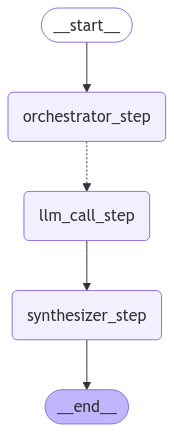

In [137]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator_step", orchestrator)
orchestrator_worker_builder.add_node("llm_call_step", llm_call)
orchestrator_worker_builder.add_node("synthesizer_step", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator_step")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator_step", assign_workers, ["llm_call_step"]
)
orchestrator_worker_builder.add_edge("llm_call_step", "synthesizer_step")
orchestrator_worker_builder.add_edge("synthesizer_step", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [138]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

## Introduction to LLMs and Scaling Laws

In recent years, the field of artificial intelligence has witnessed a significant transformation with the advent and evolution of large language models (LLMs). These models, characterized by their extensive capacity and complexity, have become pivotal in advancing natural language processing (NLP) and understanding. LLMs are essentially deep neural networks with billions, and even trillions, of parameters trained on vast corpora of text data to understand and generate human-like language. They are a subclass of machine learning models that can perform a wide array of language-related tasks, such as translation, summarization, question-answering, and even creative writing, with notable competency.

The development of LLMs is guided by a set of principles known as scaling laws, which play a crucial role in enhancing the performance and efficiency of these models. Scaling laws are empirical relationships that describe how the performance of a language model improves as the model's size, the amount of data, and the computational resources used during training are increased. The initial studies into scaling laws revealed a near-monotonic improvement in performance with an increase in these factors, highlighting a clear, predictable pathway to enhancing model capabilities.

Understanding scaling laws is vital for several reasons. Firstly, in the competitive and resource-intensive domain of artificial intelligence, scaling laws provide a roadmap to allocate resources efficiently. They allow researchers to make informed decisions about how much additional computational power or data is necessary to achieve a desired increase in performance, thus optimizing resource usage. Secondly, scaling laws help in understanding the potential and limitations of LLMs. As models scale, certain tasks that were previously challenging become increasingly manageable, which opens up new avenues for practical applications and innovations.

Moreover, scaling offers insights into trade-offs between model size, data volume, and computational costs. This knowledge is essential for balancing the efficiency and capability of models, particularly in environments where computational resources are limited or where sustainability considerations demand efficient use of resources. Furthermore, by examining the curvature of scaling laws, researchers can anticipate diminishing returns, allowing for strategic planning and prioritization in model development.

In summary, LLMs and their associated scaling laws represent a cornerstone in modern AI research and development. These models, powered by their expansive architecture and scaling principles, hold transformative potential in how machines understand and generate language, impacting various industries and applications. Understanding and effectively utilizing scaling laws is therefore integral to pushing the boundaries of what AI can achieve, paving the way for more intelligent, efficient, and capable language models.

---

### Historical Context and Development

The evolution of Large Language Models (LLMs) has been a remarkable journey of innovation, experimentation, and scaling, dating back to the foundational concepts of natural language processing in the mid-20th century. Originating from the early days of rule-based algorithms, the development of LLMs has experienced significant transformations, characterized by incremental size increases and burgeoning capabilities.

#### Early Models and Foundations

In the nascent stages of language models, statistical methods such as n-grams dominated the landscape. These models, built on probabilistic frameworks, laid the groundwork for understanding word sequences but were limited by their simplicity and inability to capture large context windows. The introduction of the Bag-of-Words (BoW) model enabled the parsing of text into discrete, manageable units, albeit without preserving order or context.

The advent of machine learning in the 1990s and early 2000s introduced neural networks, albeit modest in scale compared to contemporary standards. Recurrent Neural Networks (RNNs) and their more advanced cousin, Long Short-Term Memory (LSTM) networks, began tackling sequential data better by maintaining context through memory cells, thus marking the first significant leap in linguistic modeling.

#### The Transformation: From Small Networks to Transformers

A pivotal moment in LLM development was the introduction of the Transformer architecture as described in the seminal paper "Attention is All You Need" by Vaswani et al., in 2017. This architecture shifted the paradigm from RNNs to a self-attention mechanism that could efficiently handle long-range dependencies without recurrence. The Transformer model offered a novel way to process sequences in parallel, facilitating the training of larger models and significantly improving performance on a variety of NLP tasks.

Following the introduction of Transformers, models such as OpenAI's Generative Pre-trained Transformer (GPT) series and Google's Bidirectional Encoder Representations from Transformers (BERT) leveraged the architecture to achieve major breakthroughs. BERT's successful application of bidirectional training was revolutionary for understanding context in text, while GPT’s autoregressive nature demonstrated advancements in text generation.

#### Scaling and the Emergence of Scaling Laws

One of the primary drivers of progress in LLMs has been the empirical discovery and exploitation of scaling laws. These laws posit that as the size of a model increases, its performance across various tasks improves predictably, assuming data and computational resources scale commensurately. This realization has led to the creation of extremely large models, such as GPT-3, which has 175 billion parameters, showcasing the capability of LLMs to generate human-like text with remarkable fluency.

The pursuit of larger, more sophisticated models has been facilitated by advances in computational power, particularly GPU and TPU innovations, which have catalyzed the possible training of immense datasets. This has not only improved the models' performances but has also unlocked new capabilities such as zero-shot learning, where models generalize from related tasks without explicit training data.

#### Significant Milestones in LLM Development

Several milestones illustrate the progression of LLMs from rudimentary systems to sophisticated AI language tools:

- **1990s:** Introduction of statistical models, like n-grams, laying the groundwork for probabilistic text analysis.
- **2000s:** Development of early neural network models such as RNNs and LSTMs.
- **2017:** The publication of the "Attention is All You Need" paper and the launch of the Transformer architecture.
- **2018-2019:** The release of BERT and GPT-2, setting benchmarks in NLP tasks like sentiment analysis, question answering, and text summarization.
- **2020:** The introduction of GPT-3, demonstrating the power of scaling laws and advancing capabilities like coherent conversational abilities and complex text generation.

In conclusion, the evolution of large language models from modest beginnings to the towering giants of modern AI underscores the field's quest for scaling and optimization, fundamentally altering the landscape of machine learning and artificial intelligence. As we look toward future innovations, the trends established by these foundational developments continue guiding the trajectory of LLMs.

---

## Key Scaling Laws

Large Language Models (LLMs), such as GPT-3 and GPT-4, have showcased remarkable abilities in understanding and generating human-like text, which can largely be attributed to the scaling laws that govern their architecture and training. Understanding these critical scaling laws is paramount for optimizing model performance, guiding future innovations, and facilitating efficient resource allocation. This section outlines the essential scaling laws related to model size, dataset size, computation, and performance, providing a foundation for future advancements in the field.

### Model Size and Performance

One of the most significant scaling laws discovered in the realm of LLMs is the relationship between model size (number of parameters) and performance. Research indicates that increasing the number of parameters can lead to a proportional enhancement in the model's abilities to understand and process natural language, up to a point. The performance follows a power-law improvement, where relatively small increases in performance require exponentially larger models. Formally, this can be described by the relationship:

\[ P(n) \sim n^\alpha \]

where \( P(n) \) represents the performance metrics (such as accuracy or loss) as a function of the number of parameters \( n \), and \( \alpha \) is a constant derived empirically.

### Dataset Size and Generalization

The scaling law associated with dataset size suggests that larger datasets contribute significantly to the improvement of an LLM's generalization capability. An empirical law states that the loss of a model trained with a dataset of size \( D \) tends to decrease roughly as a power law as the dataset size increases:

\[ L(D) \sim D^{-\beta} \]

where \( L(D) \) is the loss, and \( \beta \) is a constant greater than zero. It highlights the need for vast corpora to train models effectively, enabling them to learn more nuanced features of language.

### Computation and Training Efficiency

Computation (specifically, the total compute used during training) is a critical aspect of model scaling laws. The relationship between computation and model capabilities indicates that as the computational budget (measured in FLOPs - floating point operations) increases, so does the model performance. The trade-offs involved here are crucial as they pertain to energy efficiency and cost:

\[ C \sim (T \cdot D \cdot n)^\gamma \]

Here, \( C \) represents the compute budget, \( T \) is the number of training steps, \( D \) is the dataset size, \( n \) is the number of parameters, and \( \gamma \) is a constant that dictates the efficiencies achievable through computation scaling.

### Interrelation and Practical Implications

The interplay between these scaling laws presents a complex landscape where model size, dataset availability, and computational resources must be carefully balanced to achieve optimal performance. For instance, while it may be tempting to continuously increase the number of parameters to improve results, diminishing returns can be expected if not paired with sufficiently large and diverse datasets.

Graphical illustrations of these scaling laws typically portray performance metrics or loss on the y-axis and model parameters or dataset size on the x-axis, demonstrating clear logarithmic patterns. These insights help researchers and developers ascertain efficient paths for model scaling and establish benchmarks for model capabilities as resources evolve.

In conclusion, understanding these key scaling laws is integral to the strategic development of more powerful and efficient LLMs. By adhering to these principles, we not only optimize existing models but also pave the way for the next generation of language models that can effectively wield language to facilitate a wider array of applications.

---

## Applications and Implications

The realm of Large Language Models (LLMs) has been characterized by their immense scale and corresponding capability over recent years. The concept of scaling laws has become a cornerstone in understanding and improving these models. Scaling laws refer to the mathematical relationships that outline how changes in model size, computational resources, and data scale can influence performance. This section delves into the practical applications of these scaling laws in developing LLMs, addressing their impact on various facets such as performance, cost, energy efficiency, and ethical considerations, and elucidating the broader real-world implications on technology, industry, and society.

### Performance Enhancement

Scaling laws dictate that larger models, given enough data and computation, can achieve significant advancements in capabilities and performance. By increasing model parameters and training data, researchers have been able to improve the models' ability to understand context, generate coherent and contextually relevant text, and even perform specific tasks that smaller models cannot. This makes them valuable assets for applications ranging from natural language processing (NLP) tasks like translation, sentiment analysis, and summarization to more complex applications such as machine-assisted creativity and decision-making support systems. As scaling continues, the potential to unlock increasingly sophisticated uses only grows, offering tangible benefits across sectors such as healthcare, education, and finance.

### Cost and Resource Considerations

Scaling LLMs, while beneficial in enhancing performance, does not come without significant costs. Larger models require increased computational power and memory, which translate to higher operational costs. The financial burden of developing and maintaining these models can be substantial, often limiting cutting-edge advancements to large tech firms or well-funded institutions. This economic barrier raises concerns about accessibility and inequality in technological innovation and application. To mitigate this, researchers are encouraged to innovate in algorithm efficiency and model compression techniques, allowing the benefits of scaled models to be more widely adopted without prohibitive costs.

### Energy Efficiency and Environmental Impact

The environmental implications of scaling are increasingly coming under scrutiny. Training large-scale models is notoriously energy-intensive, contributing to a growing carbon footprint. This has prompted calls for more sustainable AI practices. Researchers and practitioners are exploring ways to make LLMs more energy-efficient, such as optimizing hardware, employing energy-efficient data centers, and developing frameworks to assess and minimize environmental impact. By embedding sustainability considerations into the scaling process, the industry can align with global efforts to reduce climate impact.

### Ethical Considerations

As LLMs scale and integrate more into everyday technology, ethical considerations become paramount. Bias in data used for training can be amplified in larger models, perpetuating and even exacerbating existing prejudices and inequalities. As such, an ethical framework must accompany the scaling of LLMs to ensure that models are fair, unbiased, and accountable. This involves concerted efforts in data selection, bias detection and mitigation, and iterative testing to ensure ethical integrity.

### Real-world Implications

The real-world implications of scaling laws in LLMs are profound, shaping the trajectory of technology, industry, and society. In technology, scaling offers transformative potential in developing smarter, more intuitive AI systems. In industry, businesses can leverage these advancements to optimize processes, enhance product offerings, and improve decision-making accuracy. For society, the responsible scaling of LLMs presents opportunities for improved access to information, personalized education, and innovation in healthcare delivery, among others.

As industry and society move forward, the judicious application of scaling laws will be critical in realizing these advancements while balancing cost, efficiency, and ethical considerations. The goal is to harness our capacity for scale to benefit humanity at large, promoting inclusivity, innovation, and sustainability in the world of AI.

---

## Challenges and Limitations

Applying scaling laws to Large Language Models (LLMs) presents a variety of challenges and limitations that stakeholders must navigate to maximize the efficacy and sustainability of these models. This section delves into the multifaceted obstacles encountered in the domains of model training, resource allocation, environmental impact, and the issue of diminishing returns on performance.

### 1. Model Training Challenges

The exponential growth in model parameters required to achieve cutting-edge performance presents significant training challenges. As models scale, they demand vast amounts of data and computational power to learn effectively. This requirement introduces several hurdles:

- **Data Scarcity and Quality:** With the increasing size of LLMs, the quantity of high-quality, domain-relevant data can become a bottleneck. The lack of diverse and comprehensive datasets often limits the model's ability to generalize across different tasks and domains.
  
- **Complexity in Fine-Tuning:** Fine-tuning large models for specific tasks becomes increasingly complex as models grow larger. The need for task-specific adjustments and hyper-parameter optimization intensifies, requiring expert intervention and significant computational cost.

### 2. Resource Allocation

LLMs are characterized by their extensive resource demands, challenging both hardware and infrastructure:

- **Computational Resources:** The need for specialized hardware such as GPUs and TPUs places a strain on resource allocation. The high upfront costs and ongoing energy requirements for operating powerful clusters can be prohibitive, limiting accessibility for smaller research institutions and individual developers.

- **Scalability Issues:** As models scale, ensuring efficient parallel processing and data management becomes increasingly complex. The development of models that can optimally leverage distributed systems without significant loss in performance or efficiency remains a significant challenge.

### 3. Environmental Impact

The scaling of LLMs is increasingly scrutinized due to their environmental footprint:

- **Energy Consumption:** The colossal energy usage required to train large-scale models leads to heightened carbon emissions. Addressing this impact necessitates the adoption of sustainable practices in model training and deployment, posing financial and technical challenges.

- **Sustainability Concerns:** The need for frequent updates and retraining to maintain state-of-the-art performance further exacerbates resource consumption, raising ethical concerns about the long-term sustainability of these approaches.

### 4. Diminishing Returns on Performance

While scaling models often results in improved performance, there are diminishing returns that must be acknowledged:

- **Marginal Gains:** As models continue to enlarge, the incremental improvements in accuracy or capability tend to shrink despite the exponential increase in resources and costs. Identifying the optimal scale where benefits outweigh the costs is crucial for sustainable development.

- **Transferability and Generalization:** Larger models do not always translate to better generalization across varied tasks, and there may be diminishing performance gains in novel application scenarios. This raises questions about the scalability of LLMs for diverse real-world applications.

In conclusion, while scaling laws have facilitated significant advancements in the capabilities of LLMs, the challenges and limitations outlined above highlight the need for innovative strategies that address these barriers. Balancing performance, resource allocation, and environmental considerations will be pivotal in the journey towards responsible and effective utilization of large-scale language models.

---

## Future Directions

The burgeoning field of large language models (LLMs) continues to be a focal point of AI research, driven by scaling laws that predict the performance enhancements as models increase in size, data, and computational power. As we stand on the cusp of new advancements, it is imperative to explore where the trajectory of LLM scaling might lead us and the avenues ripe for exploration.

### Ongoing Research and Potential Breakthroughs

Research on LLM scaling laws is poised to uncover more refined insights into how various factors—such as size, architecture, and training data—affect model performance. A critical area is the exploration of diminishing returns as models grow exceedingly large. Identifying optimal scaling techniques that provide significant gains without incurring unsustainable computational costs remains a critical challenge. Researchers are investigating more efficient architectures, such as sparse transformers, which promise to deliver performance comparable to dense models but at a fraction of the computational expense.

Another potential breakthrough is in the realm of multi-modal integration. As LLMs increasingly incorporate visual, auditory, and textual data, scaling laws for multi-modal models could fundamentally transform human-computer interaction. Enhanced multi-modal capabilities may lead models to excel in tasks requiring a synthesis of diverse data forms, bringing us closer to more generalizable AI systems.

### New Methodologies and Implications

The development of innovative training methodologies will be paramount in maximizing the utility of scaled models. Techniques such as unsupervised and semi-supervised learning, continual learning, and transfer learning are likely to be pivotal. These methodologies could drive the creation of models that not only learn from vast datasets but also efficiently adapt to new information and diverse tasks with minimal additional training.

Furthermore, the introduction of hybrid models combining neural networks with symbolic reasoning systems may lead to LLMs offering more interpretable and robust outputs, thereby enhancing their application in critical areas such as healthcare, law, and autonomous systems. These advancements may necessitate the development of new theoretical frameworks for understanding and guiding the scaling of such hybrid systems.

### Influence on the Future of AI

The trajectory of LLM scaling will have profound implications for the future of AI, extending well beyond mere performance improvements. As models grow, exploiting their potential responsibly becomes crucial. Future LLMs could reshape industries by automating complex cognitive tasks, leading to increased efficiency and productivity. However, this will require addressing ethical concerns surrounding data privacy, model biases, and the environmental impact of increased computational demands.

Moreover, scaled LLMs could democratize access to advanced AI capabilities, leveling the playing field across different sectors and geographies. Reduced barriers to entry for utilizing AI could foster innovation and economic growth, especially in regions where resources for AI development have been limited.

In conclusion, while the road ahead for LLM scaling laws brims with promise, it also poses significant challenges. Future research will be integral in not only pushing the boundaries of what these models can achieve but also ensuring their deployment aligns with societal needs and values. As we advance, the responsible and judicious scaling of language models will be instrumental in harnessing their full potential to benefit humanity.

---

### Conclusion and Description

In this report, we have explored the pivotal role that scaling laws play in the development of Large Language Models (LLMs) and their consequential impact on the landscape of AI technology. The main points covered include a detailed overview of the scaling laws themselves, their contribution to enhancing the capabilities of LLMs, and the broader implications for AI advancements.

Scaling laws, characterized by their ability to predict how LLM performance improves as they are supplied with more data and computational power, have been a cornerstone in AI research. These principles have guided the expansion of model size, leading to significant breakthroughs in natural language processing, understanding, and generation. From democratizing information access to enhancing language translation, scaling laws have underpinned the remarkable improvements seen in AI applications across diverse sectors.

The significance of scaling laws extends beyond technical improvements in LLMs. They are instrumental in optimizing resource allocation in AI development, driving more efficient and effective innovations. Moreover, scaling laws have provided a framework for anticipating the growth trajectory of AI capabilities, enabling researchers and developers to strategize future developments with a clearer understanding of potential outcomes.

As AI technology continues to evolve, propelled by advancements in LLMs, the ethical implications surrounding such developments cannot be ignored. The balance between the pursuit of technological progress and the adherence to ethical considerations remains a crucial dialogue within the AI community. While scaling laws offer immense potential for transformation and impact, they also necessitate a careful examination of issues such as data privacy, algorithmic fairness, and societal consequences.

In closing, the development of LLMs through scaling laws represents a significant stride in the field of artificial intelligence. While offering numerous opportunities for innovation and problem-solving, it concurrently demands a conscientious approach to ethical considerations. It is imperative to navigate this advancing frontier with both a vision for technological achievements and a steadfast commitment to ethical principles, ensuring that AI serves to enhance human well-being and societal progress.

In [139]:
# Evalutaor_optimizer 
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="Decide if the joke is funny or not.")
    feedback:str = Field(description="If the joke is not funny , provide feedback on how to improve it.")

evaluator = llm.with_structured_output(Feedback)

In [140]:
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str


In [143]:
def llm_call_generator(state:State):
    """LLM generates a joke"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take inot account the feedback: {state['feedback']}")
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}

def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"
        

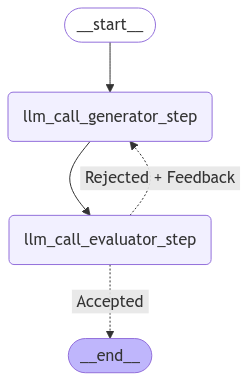

In [149]:
optimizer_builder = StateGraph(State)

optimizer_builder.add_node("llm_call_generator_step",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator_step",llm_call_evaluator)

optimizer_builder.add_edge(START,"llm_call_generator_step")
optimizer_builder.add_edge("llm_call_generator_step","llm_call_evaluator_step")

optimizer_builder.add_conditional_edges("llm_call_evaluator_step",route_joke,{ "Accepted":END,"Rejected + Feedback":"llm_call_generator_step",})

optimizer_workflow = optimizer_builder.compile()

display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [151]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [152]:
# Agents
from langchain_core.tools import tool

@tool
def multiply(a:int,b:int) -> int:
    """Multiply a and b """
    return a * b 

@tool
def add(a:int,b:int) -> int:
    """Add a and b"""
    return a + b

@tool 
def divide(a:int, b:int) -> float:
    """Divide a and b."""

tools = [add,multiply,divide]
tools_by_name = {tool.name:tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [158]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
    "messages":[
        llm_with_tools.invoke(
            [
                SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                             )] + state["messages"]
        )]}

def tool_node(state:dict):
    """Performs the tool call"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation,tool_call_id=tool_call["id"]))
        return { "messages": result } 

def should_continue(state:MessagesState) -> Literal["enviroment",END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END
            

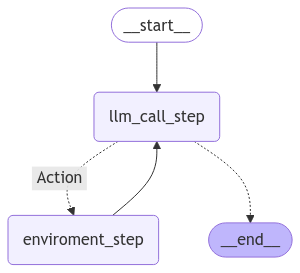

In [161]:
agent_builder = StateGraph(MessagesState)

agent_builder.add_node("llm_call_step",llm_call)
agent_builder.add_node("enviroment_step",tool_node)

agent_builder.add_edge(START,"llm_call_step")
agent_builder.add_conditional_edges("llm_call_step",should_continue, {"Action":"enviroment_step",END:END})
agent_builder.add_edge("enviroment_step","llm_call_step")

agent = agent_builder.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [162]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages":messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_XJ1mjFiZ3wbvSPabuxMM4075)
 Call ID: call_XJ1mjFiZ3wbvSPabuxMM4075
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_P1Oit3B9fYzY1GYWg6IuYTnp)
 Call ID: call_P1Oit3B9fYzY1GYWg6IuYTnp
  Args:
    a: 7
    b: 4
================================= Tool Message =================================

28
================================== Ai Message ==================================

The result of adding 3 and 4, and then multiplying the result by 4 is 28.
